## TO DO

- Delete empty images and add them to clean_dataset folder [DONE]
- Figure out how to shuffle by user, rather than by photo, make comparisons within users [DONE]
- Figure out how to do proper testing (code to pair up images randomly, predict their score using neural network, and then compare whether the ordinal match was right using our score) [DONE]

- Change training code to pull only images from new training set

### TO DO LATER
- Figure out how to incoroporate regression output
- Rewrite of code

## Create Neural Network

In [88]:
from keras import applications, optimizers
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
from keras.utils import np_utils
import cv2
import numpy as np
import csv, sqlite3
import math
import os
import random

# define the model
def larger_model():
    img_rows = 100
    img_cols = 100

    input_shape = (img_rows, img_cols, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('linear'))

    # Custom Optimizer
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=1e-6)

    # Do not forget to compile it
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    
    return model

## Train Neural Network

In [89]:
import cv2
import numpy as np
import csv, sqlite3
import math
import os
import random

In [90]:
"""
Create dictionary with:
Key = filename root
Value = score
"""

con = sqlite3.connect("imagion.db")
cur = con.cursor()

table_cols = [i[0] for i in cur.execute("SELECT * FROM slimscores").description]

def get_filenames(): 
    files_dict = {}
    
    cur.execute("SELECT filename, norm_score FROM slimscores")
    
    count = 0
    
    for file_, score in cur.fetchall():
        if count == 0:
            count += 1
            continue
        
        files_dict[file_] = score
            
        count += 1 
        
    return files_dict

files_dict = get_filenames()

In [91]:
"""
Create dictionary with:
Key = alias
Value = list of filenames for user
"""

DATASET_DIR = 'data_images'

def create_user_dict(dataset_dir):
    user_dict = {}
    
    for filename in os.listdir(dataset_dir):
        filename = filename.rsplit('.', 1)[0]
        alias = filename.rsplit('_', 1)[0]
        
        # do not include outliers
        if filename not in files_dict.keys():
            continue
            
        if alias not in user_dict:
            user_dict[alias] = [filename]
        else:
            user_dict[alias].append(filename)
            
    return user_dict

user_dict = create_user_dict(DATASET_DIR)        

In [92]:
"""Split training and test images"""

PERCENT_TRAINING = 0.75 

random.seed(10)
keys = user_dict.keys()

split = int(len(user_dict.keys()) * PERCENT_TRAINING)

random.shuffle(keys) # revisit this shuffle function

train_users = keys[:split]
test_users = keys[split:]

train_keys = []
test_keys = []

for user in train_users:
    for filename in user_dict[user]:
        train_keys.append(filename)
        
for user in test_users:
    for filename in user_dict[user]:
        test_keys.append(filename)
        
random.shuffle(train_keys)
random.shuffle(test_keys)

In [93]:
def chunks(l, n):
    """Yield successive n-sized chunks from l"""
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

def get_train_data(chunk, img_row, img_col):
    X_train = []
    Y_train = []
    
    for imgname in chunk:
        try:
            filename = 'data_images'+'/'+imgname+'.png'
            img = cv2.imread(filename)
            img = cv2.resize(img,(img_row,img_col))
            X_train.append(img)
            Y_train.append(files_dict[imgname])
        except: 
            continue
    X_train = np.asarray(X_train)
    Y_train = np.asarray(Y_train)

    return X_train,Y_train
    
def get_test_data(chunk, img_row, img_col):
    X_test = []
    Y_test = []
    
    for imgname in chunk:
        try:
            filename = './data_images'+'/'+imgname+'.png'
            img = cv2.imread(filename)
            img = cv2.resize(img,(img_row,img_col))
            X_test.append(img)
            Y_test.append(files_dict[imgname])
        except:
            continue
    X_test = np.asarray(X_test)
    Y_test = np.asarray(Y_test)

    return X_test,Y_test

def getTrainData(chunk,img_rows,img_cols):
    X_train,Y_train = get_train_data(chunk,img_rows,img_cols)
    if (X_train is not None and Y_train is not None):
        X_train/=255
    return (X_train,Y_train)

def getTestData(chunk,img_rows,img_cols):
    X_test,Y_test = get_test_data(chunk,img_rows,img_cols)
    if (X_test is not None and Y_test is not None):
        X_test/=255
    return (X_test,Y_test)

def test(model, nb_epoch, spatial_test_data, img_rows, img_cols):
    X_test,Y_test = getTestData(test_keys,img_rows,img_cols)
    return (X_test, Y_test)


In [94]:
num_epochs = 1
nb_epoch = 100
batch_size = 2
chunk_size = 32
img_rows = 100
img_cols = 100

In [9]:
for e in range(nb_epoch):
    print('-'*40)
    print 'Epoch', e
    print('-'*40)
    print "Training..."
    instance_count=0


    for chunk in chunks(train_keys, chunk_size):
        X_chunk,Y_chunk=getTrainData(chunk,img_rows,img_cols)

        if (X_chunk is not None and Y_chunk is not None):
            loss = basic_model.fit(X_chunk, Y_chunk, verbose=1, batch_size=batch_size, epochs=num_epochs)
            instance_count+=chunk_size
            
            print "Instance Count:", instance_count
            
            if instance_count%64==0:
                basic_model.save_weights('basic_model.h5',overwrite=True)

----------------------------------------
Epoch 0
----------------------------------------
Training...
Epoch 1/1
32/32 [==============================] - 13s - loss: 47.4927    
Instance Count: 32
Epoch 1/1
32/32 [==============================] - 13s - loss: 207.6136    
Instance Count: 64
Epoch 1/1
32/32 [==============================] - 12s - loss: 2.3891    
Instance Count: 96
Epoch 1/1
32/32 [==============================] - 14s - loss: 0.4943    
Instance Count: 128
Epoch 1/1
32/32 [==============================] - 14s - loss: 0.4728    
Instance Count: 160
Epoch 1/1
32/32 [==============================] - 14s - loss: 0.4305    
Instance Count: 192
Epoch 1/1
32/32 [==============================] - 14s - loss: 0.3603    
Instance Count: 224
Epoch 1/1
32/32 [==============================] - 13s - loss: 0.4121    
Instance Count: 256
Epoch 1/1
32/32 [==============================] - 14s - loss: 0.2035    
Instance Count: 288
Epoch 1/1
32/32 [==============================] - 1

KeyboardInterrupt: 

## Load Weights

In [95]:
model = larger_model()
weights_path = 'model_regress.h5'

if weights_path:
    model.load_weights(weights_path)

In [100]:
import decimal

""" SUDO CODE FOR CUSTOM ACCURACY FUNCTION"""

DATASET_DIR = 'data_images'

def test_accuracy():
    count = 0
    accuracy = 0
    
    for user in test_users:
        user_imgs = user_dict[user]
        
        if len(user_imgs) > 1:
           # get two elements from shuffled dictionary
            element1 = user_imgs.pop(0)
            element2 = user_imgs.pop(0)
            
            # read images
            img1 = cv2.imread(os.path.join(DATASET_DIR, element1+'.png'))
            img2 = cv2.imread(os.path.join(DATASET_DIR, element2+'.png'))
            
            #resize images
            img1 = cv2.resize(img1,(img_rows,img_cols))
            img2 = cv2.resize(img2,(img_rows,img_cols))
            
            # expand dimension
            img1 = np.expand_dims(img1, axis=0)
            img2 = np.expand_dims(img2, axis=0)
        
            # predict score for each image
            predict1 = float(model.predict(img1)[0][0])
            predict2 = float(model.predict(img2)[0][0])
            
            # compare whichever predicted score is higher
            
            # comparison dict
            if predict1 > predict2:
                max_predict = 'a'
            elif predict1 < predict2:
                max_predict = 'b'
            else:
                max_predict = 'equal'
            
            # compare whichever "score" is higher
            if files_dict[element1] > files_dict[element2]:
                max_actual = 'a'
            elif files_dict[element1] < files_dict[element2]:
                max_actual = 'b'
            else:
                max_actual = 'equal'

            # check if comparisons match 
            if max_predict == max_actual:
#                 print "accuracy + 1"
                accuracy+=1

            count += 1
            
#             print max_predict
#             print max_actual
#             print max_predict == max_actual
#             print '\n'
            
        else:
            continue
    

    accuracy_per = decimal.Decimal(accuracy/count)
    
    print "Correct comparisons:", accuracy    
    print "Total comparison:", count
    print "Accuracy score is:", accuracy_per
    
    return

test_accuracy()

Correct comparisons: 110
Total comparison: 222
Accuracy score is: 0


In [72]:
np.divide(58,941213)

0.0

## Predict Test

In [96]:
scores = []

for img_name in test_keys[:100]:
    img = cv2.imread('data_images/'+img_name+'.png')
    img = cv2.resize(img,(100,100))
    img = img/255
    img = np.expand_dims(img, axis=0)

    score = model.predict(img)[0][0]
    scores.append(score)
    print "Score is", score

Score is 0.619008
Score is 0.506787
Score is 0.565622
Score is 0.529178
Score is 0.348446
Score is 0.523473
Score is 0.514491
Score is 0.523473
Score is 0.523473
Score is 0.473098
Score is 0.397349
Score is 0.517655
Score is 0.561555
Score is 0.554457
Score is 0.572003
Score is 0.459835
Score is 0.511649
Score is 0.554321
Score is 0.500936
Score is 0.523473
Score is 0.60927
Score is 0.650531
Score is 0.403971
Score is 0.513574
Score is 0.726353
Score is 0.523473
Score is 0.512247
Score is 0.662315
Score is 0.529287
Score is 0.719251
Score is 0.523473
Score is 0.540397
Score is 0.61737
Score is 0.523473
Score is 0.523473
Score is 0.520972
Score is 0.523473
Score is 0.530151
Score is 0.523473
Score is 0.523473
Score is 0.523473
Score is 0.596518
Score is 0.503236
Score is 0.646928
Score is 0.523473
Score is 0.583168
Score is 0.513031
Score is 0.367362
Score is 0.661942
Score is 0.362033
Score is 0.521437
Score is 0.523473
Score is 0.460428
Score is 0.818236
Score is 0.523473
Score is 0.5

In [99]:
print len(scores)
print len(set(scores))

100
74


In [39]:
testing = []

for img_name in test_keys[:2]:
    img = cv2.imread('data_images/'+img_name+'.png')
    img = cv2.resize(img,(100,100))
    img = img/255

    testing.append(img)

In [38]:
testing[0].shape

(100, 100, 3)

## Visualize

In [43]:
import keras.backend as K

def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
#         if print_shape_only:
#             print(layer_activations.shape)
#         else:
#             print(layer_activations)
    return activations


def display_activations(activation_maps):
    import numpy as np
    import matplotlib.pyplot as plt
    """
    (1, 26, 26, 32)
    (1, 24, 24, 64)
    (1, 12, 12, 64)
    (1, 12, 12, 64)
    (1, 9216)
    (1, 128)
    (1, 128)
    (1, 10)
    """
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.imshow(activations, interpolation='None', cmap='jet')
        plt.show()

----- activations -----
Displaying activation map 0


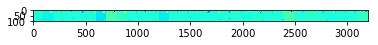

Displaying activation map 1


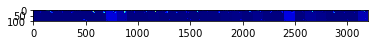

Displaying activation map 2


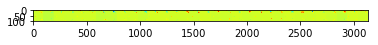

Displaying activation map 3


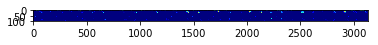

Displaying activation map 4


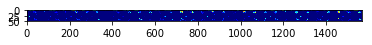

Displaying activation map 5


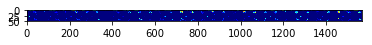

Displaying activation map 6


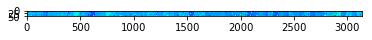

Displaying activation map 7


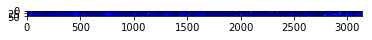

Displaying activation map 8


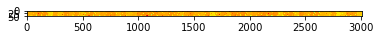

Displaying activation map 9


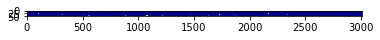

Displaying activation map 10


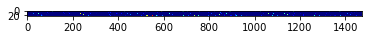

Displaying activation map 11


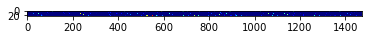

Displaying activation map 12


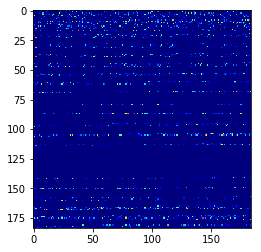

Displaying activation map 13


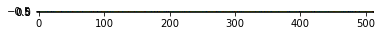

Displaying activation map 14


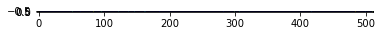

Displaying activation map 15


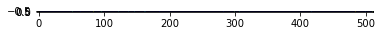

Displaying activation map 16


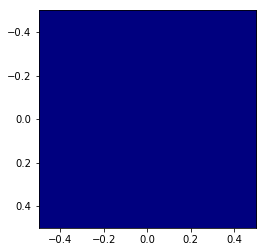

Displaying activation map 17


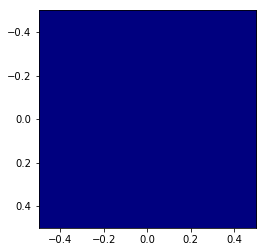

----- activations -----
Displaying activation map 0


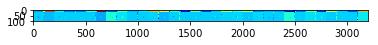

Displaying activation map 1


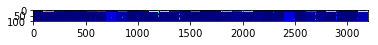

Displaying activation map 2


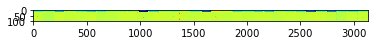

Displaying activation map 3


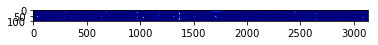

Displaying activation map 4


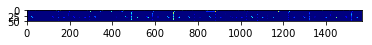

Displaying activation map 5


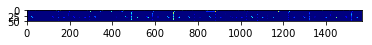

Displaying activation map 6


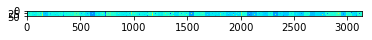

Displaying activation map 7


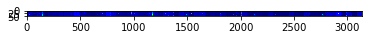

Displaying activation map 8


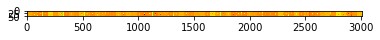

Displaying activation map 9


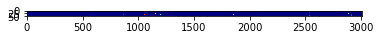

Displaying activation map 10


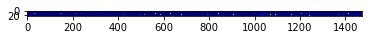

Displaying activation map 11


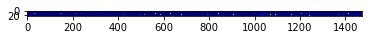

Displaying activation map 12


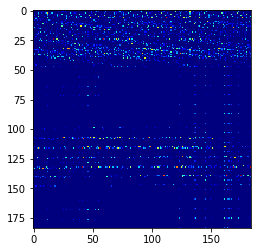

Displaying activation map 13


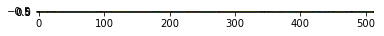

Displaying activation map 14


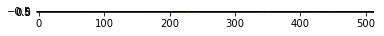

Displaying activation map 15


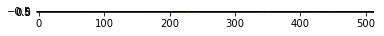

Displaying activation map 16


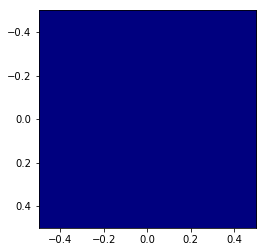

Displaying activation map 17


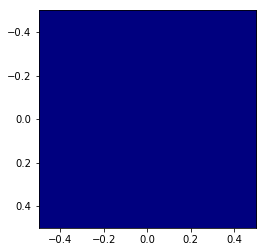

In [44]:
for image in testing:
    image = np.expand_dims(image, axis=0)
    activation_maps = get_activations(model, image, print_shape_only=False, layer_name=None)
    display_activations(activation_maps)
